## Import packages

In [1]:
from utils.FloorplanToBlenderLib import *
from PIL import Image
# from IPython.display import display
import cv2
import numpy as np
import pandas as pd
import math
import random 
import easyocr
import ctypes
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### img process

In [3]:
def remove_noise(img):
    # get binary image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to gray
    thresh = cv2.threshold(img_gray, 135, 255, cv2.THRESH_BINARY)[1] # convert to binary
    img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    # contour hierarchy
    regions, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # detect all elements
    countour_list = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        countour_list.append([x, y, w, h])
    
    # get 2nd largest contour
    countour_list = np.asarray(countour_list)  # convert to numpy-array
    column_values = ['left', 'top', 'width', 'height']
    df = pd.DataFrame(data = countour_list, columns = column_values)
    df = df.sort_values(by='width', ascending=False)

    index = df.iloc[1]
    x, y, w, h = index['left'], index['top'], index['width'], index['height']

    
    # remove outside noise
    img[:, :x] = [255, 255, 255]
    img[x + w + 1:, :] = [255, 255, 255]
    img[:y, :] = [255, 255, 255]
    img[y + h + 1:, :] = [255, 255, 255]
    
    return img



def load_easyocr_model(img):
    # get words position
    result = reader.readtext(img,
                             detail=1,
                             paragraph=True, # Combine result into paragraph
                             x_ths=0.1, # Maximum horizontal distance to merge text boxes when paragraph=True
                             y_ths=0.5, # Maximum verticall distance to merge text boxes when paragraph=True
                             # width_ths=0.1,
                             # height_ths=0.1,
                             mag_ratio=1.2,
                             )
    return result



def get_words_position(img):
    cp_list = []
    
    # load easyocr to get words position
    words_result = load_easyocr_model(img)
    
    for word in words_result:        
        # get center point of each word
        x = (word[0][1][1] + word[0][2][1]) / 2  # gey x
        y = (word[0][0][0] + word[0][1][0]) / 2  # get y
        
        # put in center of gravity list
        cp_list.append([[y, x], word[1]])

    return cp_list


def get_boxes(img):
    # get boxes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = detect.wall_filter(gray)

    gray = ~gray

    rooms, colored_rooms = detect.find_rooms(gray.copy())

    gray_rooms =  cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

    # get box positions for rooms
    boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
    
    return boxes, gray_rooms


def correct_name(val):
    # correct to the right room name
    bed_room = ['堅', '臥 室', '臥 堂', '室', '臥室']
    bth_room = ['瑜', '}', '浴廁']
    lk_room = ['裘', '更衣室']
    d_room = ['餐廳']
    l_room = ['客廳']
    kit = ['廚房']
    
    if val in bed_room: val = '臥室' # bedroom
        
    elif val in bth_room: val = '浴廁' # bathroom
        
    elif val in d_room: val = '餐廳' # dining room
        
    elif val in l_room: val = '客廳' # living room
        
    elif val in kit: val = '廚房' # kitchen
        
    else: val = '其他' # others
        
    return val


def get_room_dict(img):
    
    # build room dictionary
    room_dict = {
        '臥室':[],
        '浴廁':[],
        '餐廳':[],
        '客廳':[],
        '廚房':[],
        '其他':[],
    }
    
    # get room contour
    boxes, gray_rooms = get_boxes(img)
    
    # get center point of each room type
    cp_list = get_words_position(img)
    
    for box in boxes:
        area = cv2.contourArea(box)
        new_arr = np.reshape(np.ravel(box), (-1, 2)) # equivalent to C ravel then C reshape
        box = new_arr.tolist() # convert to python scalar
        
        # check whether the point in the box 
        polygon = Polygon(box)
        for cp in cp_list:
            point = Point(cp[0]) # cp[0] => coordinate 
            
            # if yes, add to the room dictionary
            if polygon.contains(point):
                val = correct_name(cp[1]) # check and correct to the right room name
                room_dict[val].append([box, area])

    return room_dict


def get_info(img, select_room_type):
    
    # get room coordinate and type
    room_dict = get_room_dict(img)
    
    # get coordinate(s) of specific room type
    info_list = room_dict[select_room_type]
        
    return info_list

### load easyocr model

In [2]:
reader = easyocr.Reader(['ch_tra','en']) # this needs to run only once to load the model into memory

In [10]:
# load image
img = cv2.imread("images/test7.jpg")

# process
img = remove_noise(img)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


select_room_type = '臥室'
info_list = get_info(img, select_room_type)

In [11]:
for i in info_list:
    print(i)

[[[447, 403], [447, 521], [550, 521], [550, 403]], 12154.0]
[[[445, 164], [445, 319], [553, 319], [553, 164]], 16740.0]
[[[431, 150], [400, 150], [400, 160], [399, 161], [331, 161], [329, 162], [329, 319], [431, 319]], 16456.5]
[[[159, 129], [159, 359], [160, 360], [266, 360], [270, 362], [270, 374], [345, 374], [345, 335], [318, 335], [315, 332], [315, 162], [314, 161], [191, 161], [190, 160], [190, 129]], 33844.0]


### Adjust reference to check if the text is recognized

[[612, 87], [673, 87], [673, 124], [612, 124]] ==> 陽台
[[213, 123], [263, 123], [263, 153], [213, 153]] ==> 朗蹠
[[788, 119], [848, 119], [848, 152], [788, 152]] ==> 雨遮
[[355, 200], [396, 200], [396, 278], [355, 278]] ==> 臥 室
[[477, 195], [516, 195], [516, 273], [477, 273]] ==> 臥 堂
[[118, 209], [145, 209], [145, 272], [118, 272]] ==> 遮
[[207, 212], [251, 212], [251, 294], [207, 294]] ==> 堅
[[587, 228], [663, 228], [663, 271], [587, 271]] ==> 餐廳
[[742, 220], [818, 220], [818, 263], [742, 263]] ==> 客廳
[[207, 425], [244, 425], [244, 496], [207, 496]] ==> 瑜
[[287, 398], [323, 398], [323, 498], [287, 498]] ==> 裘
[[370, 423], [409, 423], [409, 491], [370, 491]] ==> }
[[477, 410], [514, 410], [514, 488], [477, 488]] ==> 室
[[602, 420], [678, 420], [678, 461], [602, 461]] ==> 廚房
[[605, 517], [664, 517], [664, 553], [605, 553]] ==> 陽台
[[459, 533], [524, 533], [524, 570], [459, 570]] ==> 雨遮


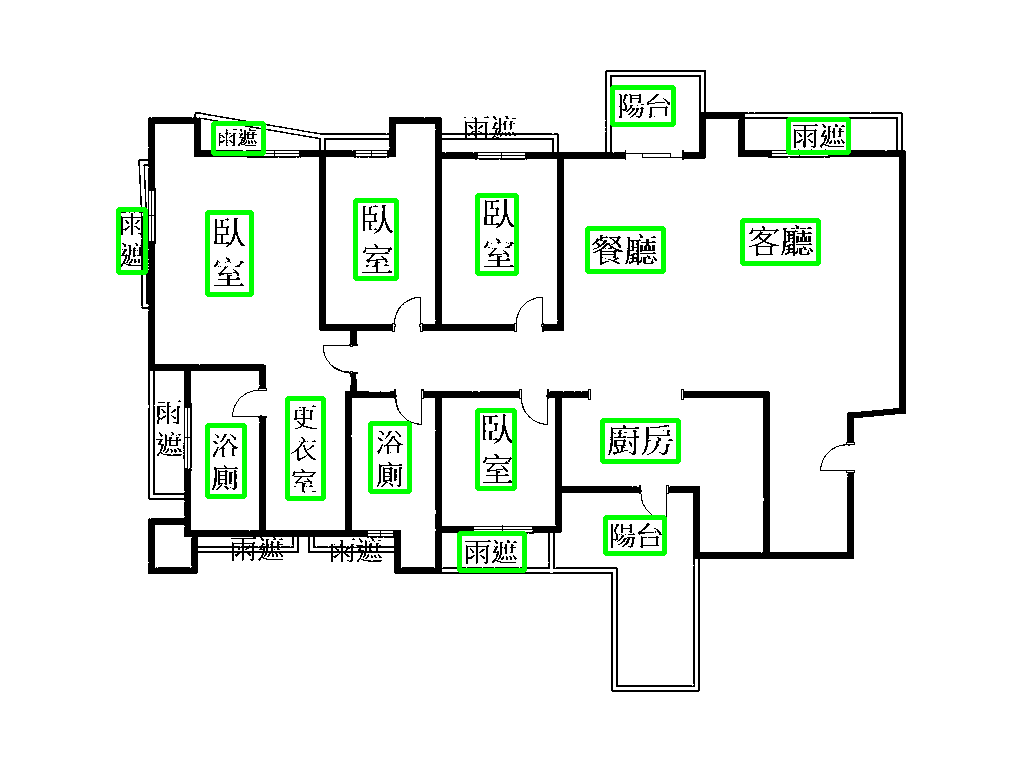

In [9]:
# image process
check_img = img.copy()

result = load_easyocr_model(check_img)

for i in result:
    
    p1x = round(i[0][0][0])
    p1y = round(i[0][0][1])
    p2x = round(i[0][2][0])
    p2y = round(i[0][2][1])
    cv2.rectangle(check_img, (p1x, p1y), (p2x, p2y), (0,255,0),3)
    
    # cx = round(i[0][0])
    # cy = round(i[0][1])
    # cv2.circle(test,(cx,cy), 10, (0,0,255), -1)
    
    print(f'{i[0]} ==> {i[1]}')

display(Image.fromarray(check_img))

### Detect Contours (Object Filter)

In [ ]:
detect.detectOuterContours?

In [ ]:
# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height, width, 3), np.uint8)


# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img_contour = detect.detectOuterContours(gray, blank_image, color=(255, 0, 0))

display(Image.fromarray(img_contour))

### Check accuracy

coord: [[159, 129], [159, 359], [160, 360], [266, 360], [270, 362], [270, 374], [345, 374], [345, 335], [318, 335], [315, 332], [315, 162], [314, 161], [191, 161], [190, 160], [190, 129]]
area: 33844.0


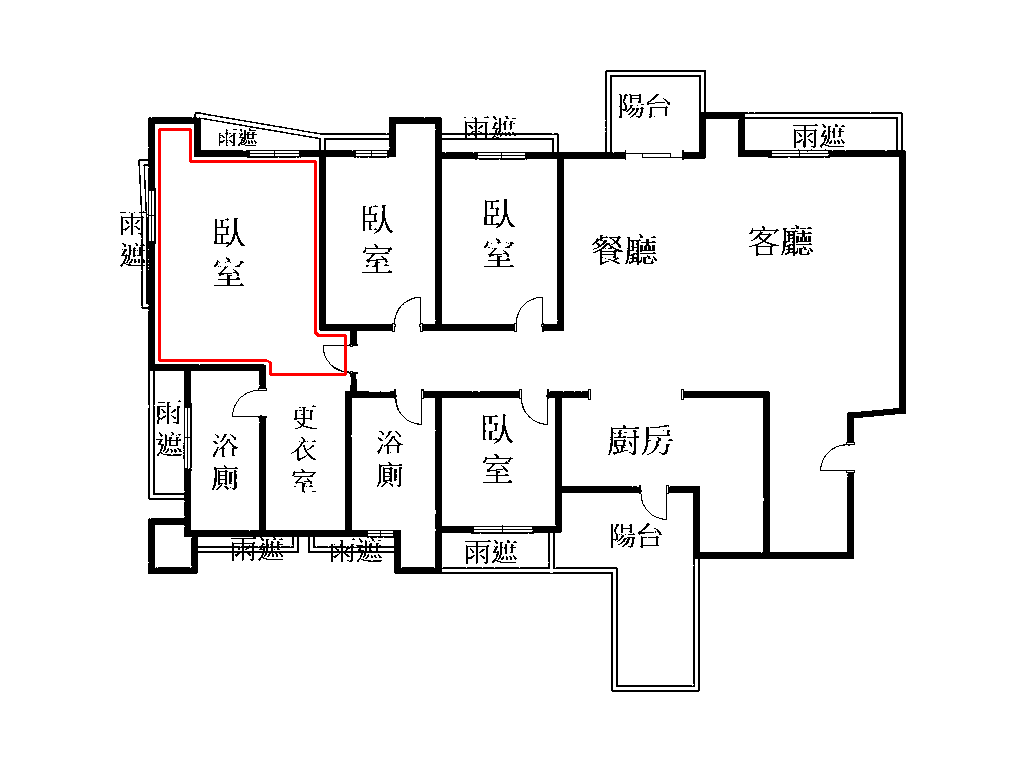

In [28]:
# only for check room type
n = len(info_list)

rnd = random.randint(0, n -1)
# rnd=6

test_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

pts = np.array(info_list[rnd][0])
 
# Using cv2.polylines() method drawing the contour
test_bgr = cv2.polylines(test_bgr, 
                         [pts],
                         True, # isClosed 
                         (255, 0, 0), # color 
                         2, # thickness
                        )

print(f'coord: {info_list[rnd][0]}\narea: {info_list[rnd][1]}')
display(Image.fromarray(test_bgr))

In [ ]:
for i in room_list:
    print(i)

In [ ]:
# from memory get value
# for i in mem_list:
#     val = ctypes.cast(i, ctypes.py_object).value
#     print(val)


### Monument for Mingyao's code

In [ ]:
for index,value in enumerate(box_pos):
    for i,j in xylist:
        print(value.min(axis=1).max())
        print(value.min(axis=1).min())
        print(i)
        if i > value.min(axis=1).min() and i < value.min(axis=1).max():
            print('yes')
        else:
            print('no')
    # print(value)